# Predict yet to arrive 

The notebook shows how to prepare a model that will predict the number of patients yet to arrive.

Inputs
- A series of times in the day at which we want to make these predictions is set, saved in an array called prediction_times. Each prediction time is saved as a tuple. Eg 6 am is saved as (6,0)
- A series of dates on which we want to make these predictions
- A window after the prediction time, within which we are interested in predicting a number of patients (eg 8 hours)

## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from pathlib import Path
import sys
import json
import pandas as pd

PROJECT_ROOT = Path().home() 
USER_ROOT = Path().home() / 'work'

sys.path.append(str(USER_ROOT / 'patientflow' / 'src' / 'patientflow'))


# media_file_path.mkdir(parents=True, exist_ok=True)

## Load parameters

These are set in config.json. You can change these for your own purposes. But the times of day will need to match those in the provided dataset if you want to run this notebook successfully.

In [3]:
uclh = True

if uclh:
    
    model_file_path = USER_ROOT / 'ed-predictor' / 'trained-models'
    data_path = USER_ROOT / 'ed-predictor' / 'data-raw'
    media_file_path = USER_ROOT / 'ed-predictor' / 'media'
    media_file_path.mkdir(parents=True, exist_ok=True)

else:
    
    model_file_path = USER_ROOT / 'patientflow' / 'trained-models'
    data_path = USER_ROOT / 'patientflow' / 'data-raw'
    media_file_path = USER_ROOT / 'patientflow' / 'notebooks' / 'img'

In [3]:
# Alternative approach (not using ed-predictor as a data source)
uclh = False
from load import set_file_paths
data_file_path, media_file_path, model_file_path, config_path = set_file_paths(data_folder_name = 'data-raw', uclh = uclh, from_notebook = True)

In [4]:
from load import load_config_file

params = load_config_file(config_path)

prediction_times = params[0]
start_training_set, start_validation_set, start_test_set, end_test_set = params[1:5]
x1, y1, x2, y2 = params[5:9]
prediction_window = params[9]
epsilon = params[10]
time_interval = params[11]



## Load data

In [6]:
import pandas as pd
from load import set_data_file_names

if uclh:
    data_path = USER_ROOT / 'ed-predictor' / 'data-raw'
    model_file_path = USER_ROOT / 'ed-predictor' / 'trained-models'
    visits_path, visits_csv_path, yta_path, yta_csv_path = set_data_file_names(uclh, data_file_path, config_path)
else:
    visits_csv_path, yta_csv_path = set_data_file_names(uclh, data_file_path)

yta = pd.read_csv(yta_csv_path)



In [6]:
yta.head()

,training_validation_test,arrival_datetime,sex,specialty,is_child
0,train,2030-11-01 17:40:00+00:00,F,surgical,False
1,train,2030-06-13 19:51:00+00:00,F,haem/onc,False
2,train,2030-04-03 17:39:00+00:00,F,haem/onc,False
3,train,2030-04-12 19:00:00+00:00,F,haem/onc,False
4,train,2030-04-05 18:24:00+00:00,F,haem/onc,False


## Separate into training, validation and test sets

As part of preparing the data, each visit has already been allocated into one of three sets - training, vaidation and test sets. 

In [7]:
yta.training_validation_test.value_counts()

training_validation_test
train    22025
test      7705
valid     2493
Name: count, dtype: int64

In [9]:
train_yta = yta[yta.training_validation_test == 'train']#.drop(columns='training_validation_test')
valid_yta = yta[yta.training_validation_test == 'valid']#.drop(columns='training_validation_test')
test_yta = yta[yta.training_validation_test == 'test']#.drop(columns='training_validation_test')


# assert pd.to_datetime(train_yta['arrival_datetime'], utc = True).dt.date.min() == start_training_set
# assert pd.to_datetime(train_yta['arrival_datetime'], utc = True).dt.date.max() < start_validation_set
# assert pd.to_datetime(valid_yta['arrival_datetime'], utc = True).dt.date.min() == start_validation_set
# assert pd.to_datetime(valid_yta['arrival_datetime'], utc = True).dt.date.max() < start_test_set
# assert pd.to_datetime(test_yta['arrival_datetime'], utc = True).dt.date.min() == start_test_set
# assert pd.to_datetime(test_yta['arrival_datetime'], utc = True).dt.date.max() < end_test_set

The Poisson-Binomial model requires as input a dataframe with the index set as the arrival datetimes of each visit. We set that here

In [10]:
train_yta['arrival_datetime'] = pd.to_datetime(train_yta['arrival_datetime'], utc = True)
train_yta.set_index('arrival_datetime', inplace=True)

/var/folders/lr/pm79dxzs0v70y4gz98dl13440000gn/T/ipykernel_31659/3438003292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_yta['arrival_datetime'] = pd.to_datetime(train_yta['arrival_datetime'], utc = True)


In [10]:
isinstance(train_yta.index, pd.DatetimeIndex)

True

## Train the Poisson-Binomial model

The Poisson-Binomial model provides a way to predict yet to arrive patients under the assumption that the ED is meeting targets for how long it takes to admit patients. The aspirational targets are set as parameters in config.yaml and have been loaded at the top of this notebook. 

To see the parameters:

In [11]:
print(f'The aspiration is that within {str(x1)} hours of arrival, {str(y1*100)}% of patients will have been admitted, and that witin {str(x2)} hours of arrival, {str(y2*100)}% of patients will have been admitted')

The aspiration is that within 4.0 hours of arrival, 76.0% of patients will have been admitted, and that witin 12.0 hours of arrival, 99.0% of patients will have been admitted


The aspiration can be plotted as a curve to see the shape of the curve. Here we have assumed that the majority of admissions happen between 3 and 4 hours of arrival, where the slope of the curve is steepest. 

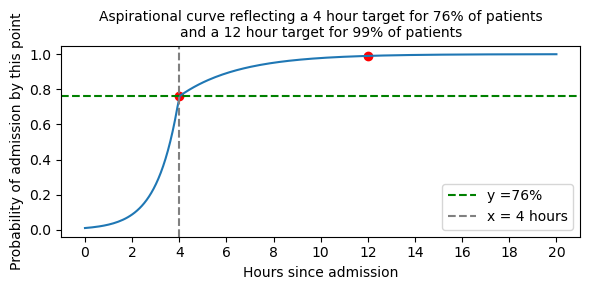

In [12]:
from viz.aspirational_curve_plot import plot_curve

figsize = (6,3)

plot_curve(
    title = 'Aspirational curve reflecting a ' + str(int(x1)) + ' hour target for ' + str(int(y1*100)) + \
        '% of patients\nand a '+ str(int(x2)) + ' hour target for ' + str(int(y2*100)) + '% of patients',
    x1 = x1,
    y1 = y1,
    x2 = x2,
    y2 = y2,
    include_titles=True,
    text_size=None,
    directory_path=None,
    file_name=None,
)


### Predict for all admissions, irrespective of specialty of admission

In [13]:
from predictors.poisson_binomial_predictor import PoissonBinomialPredictor
from joblib import dump, load

model =  PoissonBinomialPredictor()

model.fit(train_yta, prediction_window, time_interval, prediction_times)

MODEL__ED_YETTOARRIVE__NAME = 'ed_yet_to_arrive_all_' + str(int(prediction_window/60)) + '_hours'
full_path = model_file_path / MODEL__ED_YETTOARRIVE__NAME 
full_path = full_path.with_suffix('.joblib')

dump(model, full_path)

Calculating time-varying arrival rates for data provided, which spans 518 unique dates
Poisson Binomial Predictor trained for these times: [(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)]
using prediction window of 480 minutes after the time of prediction
and time interval of 15 minutes within the prediction window.
The error value for prediction will be 1e-07
To see the weights saved by this model, used the get_weights() method


['/home/jovyan/work/ed-predictor/trained-models/ed_yet_to_arrive_all_8_hours.joblib']

To see the predicted distribution of patients yet-to-arrive at 6.00 am, call the model as follows:

In [14]:
prediction_context = {
    'default': {
        'prediction_time': tuple([7, 0])  
    }
}

MODEL__ED_YETTOARRIVE__NAME = 'ed_yet_to_arrive_all_' + str(int(prediction_window/60)) + '_hours'
full_path = model_file_path / MODEL__ED_YETTOARRIVE__NAME 
full_path = full_path.with_suffix('.joblib')

model = load(full_path)

preds = model.predict(prediction_context, x1, y1, x2, y2)
preds

/home/jovyan/work/patientflow/src/patientflow/predictors/poisson_binomial_predictor.py:212: UserWarning: Time of day requested of (7, 0) was not in model training. Reverting to predictions for (6, 0).
  warnings.warn(


{'default':      agg_proba
 sum           
 0     0.001013
 1     0.006983
 2     0.024073
 3     0.055329
 4     0.095375
 ..         ...
 284   0.000000
 285   0.000000
 286   0.000000
 287   0.000000
 288   0.000000
 
 [289 rows x 1 columns]}

To see the output visually we can plot this using the 

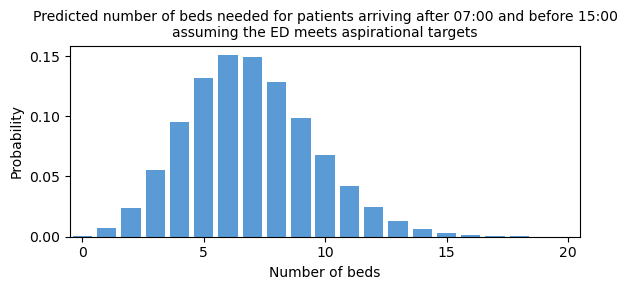

In [15]:
from viz.prob_dist_plot import prob_dist_plot

hour, minute = prediction_context['default']['prediction_time']
start_time = f"{hour:02}:{minute:02}"
end_time = f"{int(hour + prediction_window / 60):02}:{minute:02}"

title = f"Predicted number of beds needed for patients arriving after {start_time} and before {end_time}\nassuming the ED meets aspirational targets"

prob_dist_plot(preds['default'], 
               title=title, 
               include_titles=True)

### Predict within specialty

To train a model of yet-to-arrive patients within specialty, we can use filters as shown below. Here, if an arrival is a child, we assume they will be admitted to a paediatric specialty by default

In [15]:
from predictors.poisson_binomial_predictor import PoissonBinomialPredictor
from joblib import dump, load

specialty_filters = {
    'medical': {'specialty': 'medical', 'is_child': False},
    'surgical': {'specialty': 'surgical', 'is_child': False},
    'haem/onc': {'specialty': 'haem/onc', 'is_child': False},
    'paediatric': {'is_child': True}  # Pediatric doesn't filter by observed_specialty
}

model_by_spec =  PoissonBinomialPredictor(filters = specialty_filters)

model_by_spec.fit(train_yta, prediction_window, time_interval, prediction_times)


MODEL__ED_YETTOARRIVE__NAME = 'ed_yet_to_arrive_by_spec_' + str(int(prediction_window/60)) + '_hours'
full_path = model_file_path / MODEL__ED_YETTOARRIVE__NAME 
full_path = full_path.with_suffix('.joblib')

dump(model_by_spec, full_path)

Calculating time-varying arrival rates for data provided, which spans 518 unique dates
Calculating time-varying arrival rates for data provided, which spans 518 unique dates
Calculating time-varying arrival rates for data provided, which spans 511 unique dates
Calculating time-varying arrival rates for data provided, which spans 511 unique dates
Poisson Binomial Predictor trained for these times: [(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)]
using prediction window of 480 minutes after the time of prediction
and time interval of 15 minutes within the prediction window.
The error value for prediction will be 1e-07
To see the weights saved by this model, used the get_weights() method


['/Users/zellaking/Repos/patientflow/trained-models/ed_yet_to_arrive_by_spec_8_hours.joblib']

In [16]:
MODEL__ED_YETTOARRIVE__NAME = 'ed_yet_to_arrive_by_spec_' + str(int(prediction_window/60)) + '_hours'
full_path = model_file_path / MODEL__ED_YETTOARRIVE__NAME 
full_path = full_path.with_suffix('.joblib')

model_by_spec = load(full_path)

prediction_context = {
    'medical': {
        'prediction_time': tuple([7, 0])  
    }
}

preds = model_by_spec.predict(prediction_context, x1, y1, x2, y2)
preds['medical']

/Users/zellaking/Repos/patientflow/src/patientflow/predictors/poisson_binomial_predictor.py:212: UserWarning: Time of day requested of (7, 0) was not in model training. Reverting to predictions for (6, 0).
  warnings.warn(


,agg_proba
sum,
0,0.032559
1,0.111506
2,0.190936
3,0.217966
4,0.186616
...,...
220,0.000000
221,0.000000
222,0.000000


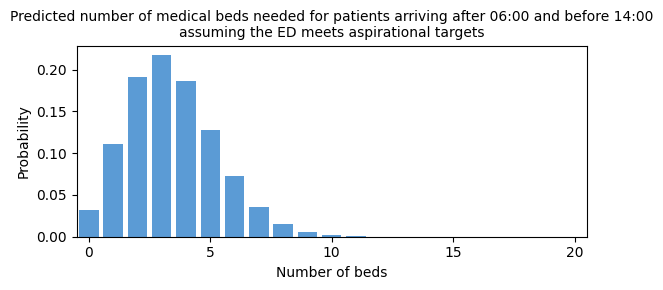

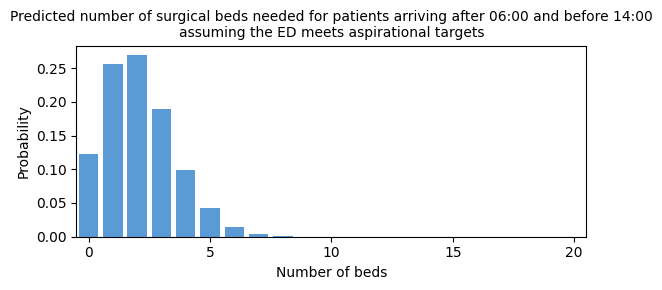

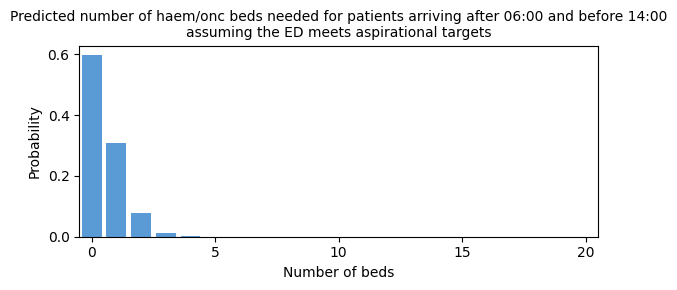

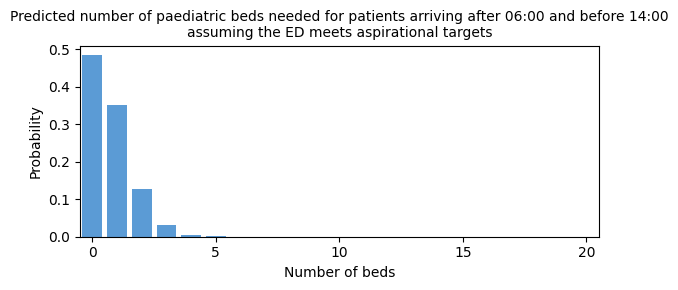

In [18]:
from viz.prob_dist_plot import prob_dist_plot

for spec in specialty_filters:
    prediction_context = {
    spec: {
        'prediction_time': tuple([6, 0])  
        }
    }

    preds = model_by_spec.predict(prediction_context, x1, y1, x2, y2)

    hour, minute = prediction_context[spec]['prediction_time']
    start_time = f"{hour:02}:{minute:02}"
    end_time = f"{int(hour + prediction_window / 60):02}:{minute:02}"

    title = f"Predicted number of {spec} beds needed for patients arriving after {start_time} and before {end_time}\nassuming the ED meets aspirational targets"

    prob_dist_plot(preds[spec], 
                title=title, 
                include_titles=True) 

In [13]:
from prepare import create_special_category_objects


def create_yta_filters(uclh):
    # Get the special category parameters
    special_params = create_special_category_objects(uclh)

    # Extract necessary functions and data from the special_params
    special_category_dict = special_params["special_category_dict"]
    special_category_func = special_params["special_category_func"]
    
    # Create the specialty_filters dictionary
    specialty_filters = {}
    
    for specialty, is_paediatric_flag in special_category_dict.items():
        if is_paediatric_flag == 1.0:
            # For the paediatric specialty, set `is_child` to True
            specialty_filters[specialty] = {'is_child': True}
        else:
            # For other specialties, set `is_child` to False
            specialty_filters[specialty] = {
                'specialty': specialty, 
                'is_child': False
            }

    return specialty_filters

specialty_filters = create_yta_filters(uclh)